In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib import rcParams
from scipy.optimize import curve_fit
from cycler import cycler

In [258]:
plt.rcdefaults()

# axes
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['axes.prop_cycle'] = cycler('color', ['teal', 'firebrick', 'darkgoldenrod', 'navy', 'olive', 'darkorchid', 'slategray', 'mediumvioletred', 'saddlebrown', 'black'])

# figure:
rcParams['figure.autolayout'] = True
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [7.4, 4.8]


# fontsizes
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['legend.title_fontsize'] = 12
rcParams['axes.labelsize'] = 16
# rcParams['axes.title.size'] = 16

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'

# legend
# rcParams['legend.framealpha'] = 1
rcParams['legend.fancybox'] = False
rcParams['legend.edgecolor'] = 'gray'


# save
rcParams['savefig.bbox'] = 'tight'

In [259]:
def uno_sobre_r(r, a, d):
    return d + a/r

# def rankine(r, R, a, d):
#     return np.piecewise(r, [r < R, r>=R], [lambda r: d + a*r/(R**2), lambda r: d + a/r])

# def rankine(r, R, a):
#     res = np.array([])
#     for value in r:
#         if value < R:
#             res = np.append(res, a*value/(R**2))
#         elif value >= R:
#             res = np.append(res, a/value)
#     return res


# def burgers(r, b, c):
#     return b*(1 - np.exp((-r**2)/(c**2)))/r


def burgers(r, Gamma, a):
    C = Gamma / (2*np.pi)
    return C *  (1 - np.exp(-r**2 / a**2)) / r

def rankine(r, Gamma, a):
    C = Gamma / (2*np.pi)
    return np.piecewise(r, [r < a, r >= a], [lambda x : C * x / (a**2), lambda x : C / x])

def chi2_reducido(x, y, func, params, *, y_err):
    """Calcula el chi^2 reducido a partir de los datos (x, y),
    la función ajustada (`func`) y los parámetros óptimos (`params`).
    """
    n_datos = y.size
    n_params = len(params)
    y_pred = func(x, *params)
    residuos = y - y_pred
    return np.sum((residuos / y_err) ** 2) / (n_datos - n_params)

In [260]:
# extracción de datos
data = pd.read_csv('Mediciones/solo agua clase2_1.txt', header = 0, names = ['x', 'y', 'u', 'v', 'tipo'], dtype = {'x': np.float64, 'y': np.float64, 'u': np.float64, 'v': np.float64, 'tipo': np.int32}, skiprows=2)
x_NaN, y_NaN, u_NaN, v_NaN, tipo = np.array(data['x']), np.array(data['y']), np.array(data['u']), np.array(data['v']), np.array(data['tipo'])

print(np.mean(np.isnan(x_NaN)), np.mean(np.isnan(y_NaN)), np.mean(np.isnan(u_NaN)), np.mean(np.isnan(v_NaN)))
print(len(x_NaN), len(y_NaN), len(u_NaN), len(v_NaN))

u = u_NaN[~np.isnan(u_NaN)]
v = v_NaN[~np.isnan(v_NaN)]
x = x_NaN[~np.isnan(v_NaN)]
y = y_NaN[~np.isnan(u_NaN)]

print(np.mean(np.isnan(x)), np.mean(np.isnan(y)), np.mean(np.isnan(u)), np.mean(np.isnan(v)))
print(len(x), len(y), len(u), len(v))

t = np.arange(0, len(x))/30

err_t = 1/30
err_x = x[1] - x[0]
err_y = y[1] - y[0]
err_u = np.sqrt(2)*err_x/err_t
err_v = np.sqrt(2)*err_y/err_t

0.0 0.0 0.49787414965986393 0.49787414965986393
2352 2352 2352 2352
0.0 0.0 0.0 0.0
1181 1181 1181 1181


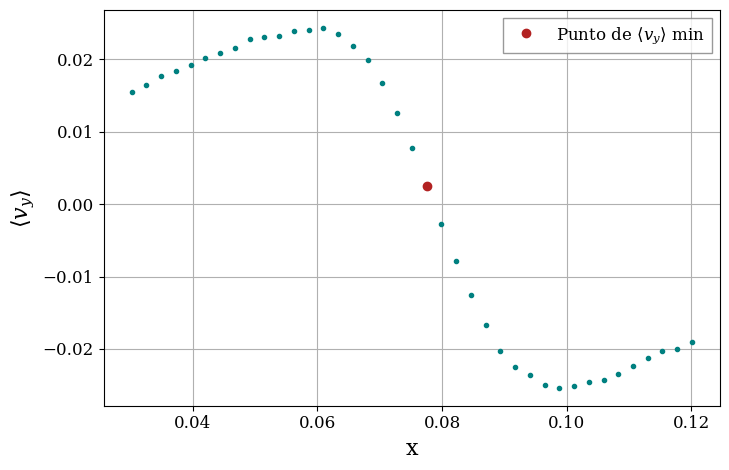

In [261]:
# cálculo del centro en x
valores_x = [x[0]]
indices_x = [0]
for i in range(len(x)):
    if x[i] != valores_x[-1]:
        indices_x.append(np.nonzero(x == x[i])[0][0])
        valores_x.append(x[i])

v_mean = np.array([np.mean(v[indices_x[n]:indices_x[n+1]]) for n in range(len(valores_x)-1)] + [np.mean(v[indices_x[-1]:])])

v_abs = abs(v_mean)
min_v = v_mean[np.where(v_abs == min(v_abs[len(v_abs)//3:2*len(v_abs)//3]))[0][0]]
centro_x = valores_x[np.where(v_abs == min(v_abs[len(v_abs)//3:2*len(v_abs)//3]))[0][0]]

fig, ax = plt.subplots()
ax.plot(valores_x, v_mean, '.')
# ax.plot(valores_x[len(valores_x)//3:2*len(valores_x)//3], v_mean[len(v_mean)//3:2*len(v_mean)//3], '.')
ax.plot(centro_x, min_v, 'o', label=r'Punto de $\langle v_y \rangle$ min')
ax.set_xlabel('x')
ax.set_ylabel(r'$\langle v_y \rangle$')
ax.legend()
# plt.savefig('Gráficos/centro x.pdf', format='pdf', dpi=150)

Coordenadas del centro:(0.077505216, 0.1161099151)


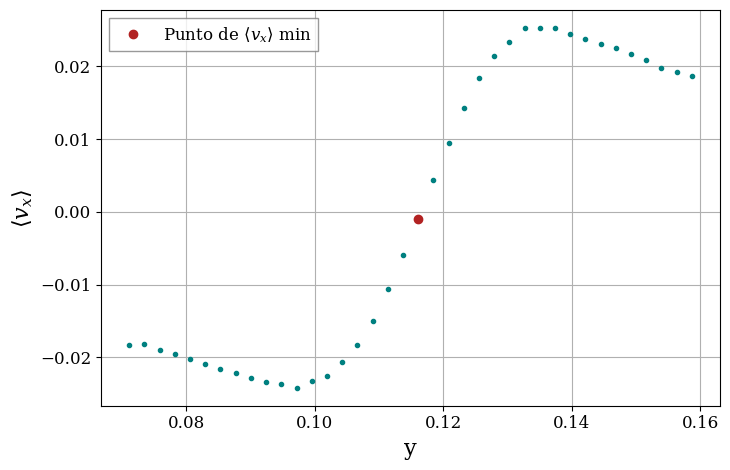

In [262]:
# cálculo del centro en y

valores_y = [y[0]]  
for i in range(len(y)):
    if y[i] not in valores_y:
        valores_y.append(y[i])

valores_y.sort()

valores_u = [[] for i in range(len(valores_y))]
for i, val_y in enumerate(y):
    ind = valores_y.index(val_y)
    valores_u[ind].append(u[i])

u_mean = np.array([np.mean(l) for l in valores_u])
u_abs = abs(u_mean)
min_u = u_mean[np.where(u_abs == min(u_abs[len(u_abs)//3:2*len(u_abs)//3]))[0][0]]
centro_y = valores_y[np.where(u_abs == min(u_abs[len(u_abs)//3:2*len(u_abs)//3]))[0][0]]


fig1, ax1 = plt.subplots()
# ax1.plot(y, u, '.')
ax1.plot(valores_y, u_mean, '.')
# ax1.plot(valores_y[len(valores_y)//3:2*len(valores_y)//3], u_mean[len(u_mean)//3:2*len(u_mean)//3], '.')
ax1.plot(centro_y, min_u, 'o', label=r'Punto de $\langle v_x \rangle$ min')
ax1.set_xlabel('y')
ax1.set_ylabel(r'$\langle v_x \rangle$')
ax1.legend()

print(f'Coordenadas del centro:{(centro_x, centro_y)}')
# plt.savefig('Gráficos/centro y.pdf', format='pdf', dpi=150)

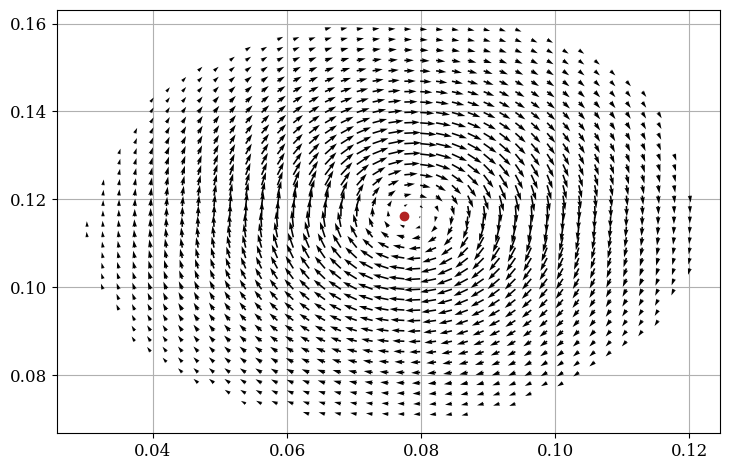

In [263]:
fig, ax = plt.subplots()
Q = ax.quiver(x, y, u, v)
ax.plot(centro_x, centro_y, 'o', color='firebrick')
# qk = ax.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')

In [264]:
x = x-centro_x
y = y-centro_y

r = np.sqrt(x**2 + y**2)
tita = np.arctan2(y, x)

v_rNaN = (u*x + v*y)/np.sqrt(x**2 + y**2)
v_titaNaN = ((x * v) - (y * u))/np.sqrt(x**2 + y**2)

v_r = v_rNaN[~np.isnan(v_rNaN)] # le saco los NaN
v_tita = v_titaNaN[~np.isnan(v_titaNaN)] # le saco los NaN

r_fix = r[~np.isnan(v_titaNaN)] # le saco los valores de r que corresponden a NaN en v_titaNaN

# err_v_tita = np.sqrt((-v_tita*y/(r_fix**2) + v/r_fix)*err_x )

ListaPromedios1 = np.array([])
ListaPromediosErrores1 = np.array([])
r_medios = np.arange(min(r_fix), max(r_fix), 0.0005)

listas = np.array([])

for n, rm in enumerate(r_medios):
  lista = np.array([])
  for i in range(len(r_fix)):
    if r_fix[i] >= rm and r_fix[i] <= (rm+0.0005):
      lista = np.append(lista, v_tita[i])
  a = np.mean(lista)
  b = np.std(lista)/np.sqrt(len(lista))
  ListaPromedios1 = np.append(ListaPromedios1, a)
  ListaPromediosErrores1 = np.append(ListaPromediosErrores1, b)

r_medios = r_medios[~np.isnan(ListaPromedios1)]
ListaPromedios1 = ListaPromedios1[~np.isnan(ListaPromedios1)]
ListaPromediosErrores1 = ListaPromediosErrores1[~np.isnan(ListaPromediosErrores1)]

C:\Users\pauli\AppData\Local\Temp\ipykernel_40876\395273718.py:7: RuntimeWarning: invalid value encountered in divide
  v_rNaN = (u*x + v*y)/np.sqrt(x**2 + y**2)
C:\Users\pauli\AppData\Local\Temp\ipykernel_40876\395273718.py:8: RuntimeWarning: invalid value encountered in divide
  v_titaNaN = ((x * v) - (y * u))/np.sqrt(x**2 + y**2)
c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: inv

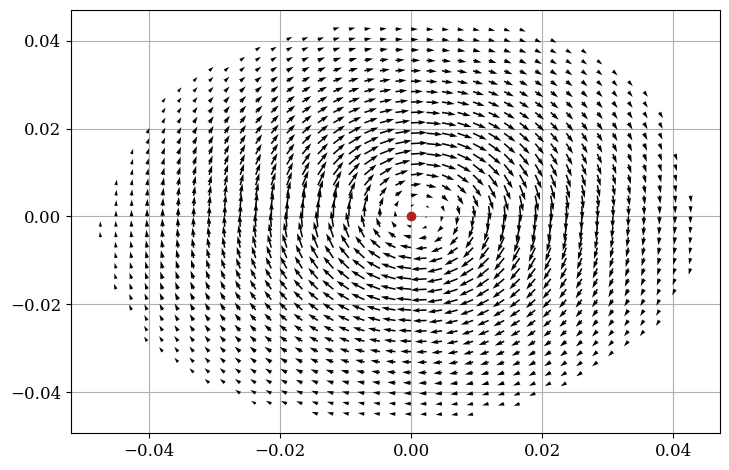

In [265]:
# chequeando que esté bien trasladado el origen
fig, ax = plt.subplots()
Q = ax.quiver(x, y, u, v)
ax.plot(0, 0, 'o', color='firebrick')

In [266]:
print(len(r_medios))

r_array_b = np.linspace(r_medios[0], r_medios[49], 1000)

# BURGERS
popt_b, pcov_b = curve_fit(burgers, r_medios[:50], -ListaPromedios1[:50])

R = popt_b[1]
print(f'Radio característico; {R}')

# RANKINE
# PARTIDA (NO ANDA)
# popt_r, pcov_r = curve_fit(rankine, r_medios[:6], -ListaPromedios1[:6]) # no funca

# SEPARANDO (NO SÉ SI ESTO ESTÁ BIEN PORQUE ESTOY ELIGIENDO YO EL RADIO DEL VÓRTICE)

iR = np.abs(r_medios-R).argmin()

def lineal(r, a, d):
    return d + a*r/(R**2)

r_array_r1 = np.linspace(r_medios[0], r_medios[iR], 100)
r_array_r2 = np.linspace(r_medios[iR], r_medios[70], 1000)

# r < R
popt_r1, pcov_r1 = curve_fit(lineal, r_medios[:iR], -ListaPromedios1[:iR])
Gamma, c = popt_r1

# r >= R
popt_r2, pcov_r2 = curve_fit(uno_sobre_r, r_medios[iR:71], -ListaPromedios1[iR:71], p0 = [Gamma, c])

chi2_b = chi2_reducido(r_medios[:50], -ListaPromedios1[:50], burgers, popt_b, y_err = ListaPromediosErrores1[:50])
chi2_r = chi2_reducido(r_medios[iR:71], -ListaPromedios1[iR:71], uno_sobre_r, popt_r2, y_err = ListaPromediosErrores1[iR:71])
# print(ListaPromediosErrores1[0:50], iR)
# print(chi2_b, chi2_r)

# R^2

s_res = np.sum((-ListaPromedios1[:iR] - lineal(r_medios[:iR], *popt_r1))**2)
t_res = np.sum((-ListaPromedios1[:iR] - np.mean(-ListaPromedios1[:iR]))**2)

R_cuad = 1 - s_res/t_res
print(f'R cuadrado lineal: {R_cuad}')
print(f'Chi^2 burgers:{chi2_b}\nChi^2 1/r: {chi2_r}')


81
Radio característico; 0.013574573841420782
R cuadrado lineal: 0.9763529974421505
Chi^2 burgers:3.4038721645370273
Chi^2 1/r: 253.3001704577053


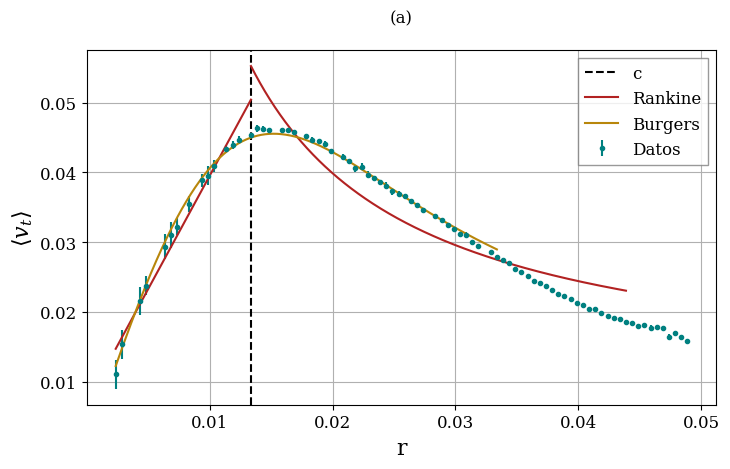

In [267]:
fig, ax = plt.subplots()
ax.errorbar(r_medios, -ListaPromedios1, ListaPromediosErrores1, ls='none', marker='.', label='Datos')
ax.axvline(r_medios[iR], linestyle='dashed', color='k', label='c')
# ax.plot(r_array, rankine(r_array, *popt_r))
ax.plot(r_array_r1, lineal(r_array_r1, *popt_r1), label='Rankine')
ax.plot(r_array_r2, uno_sobre_r(r_array_r2, *popt_r2), color='firebrick')
ax.plot(r_array_b, burgers(r_array_b, *popt_b), label='Burgers')
ax.set_xlabel('r')
ax.set_ylabel(r'$\langle v_t \rangle$')
ax.legend()
ax.set_title('(a)\n')

plt.savefig('Gráficos/100 agua.pdf', format='pdf', dpi=150)